# 实战Kaggle⽐赛：房价预测
作为深度学习基础篇章的总结，我们将对本章内容学以致⽤。下⾯，让我们动⼿实战⼀个Kaggle⽐
赛：房价预测。本节将提供未经调优的数据的预处理、模型的设计和超参数的选择。我们希望读
者通过动⼿操作、仔细观察实验现象、认真分析实验结果并不断调整⽅法，得到令⾃⼰满意的结
果。
## Kaggle⽐赛
[Kaggle](https://www.kaggle.com)是⼀个著名的供机器学习爱好者交流的平台。
图3.7展⽰了Kaggle⽹站的⾸⻚。为了便于提交结果，需要注册Kaggle账号。

![Kaggle网站首页](../img/kaggle.png)

我们可以在房价预测比赛的网页上了解比赛信息和参赛者成绩，也可以下载数据集并提交自己的预
测结果。该比赛的网页地址是 https://www.kaggle.com/c/house-prices-advanced-regression-techniques 

图3.8展⽰了房价预测⽐赛的⽹⻚信息

![房价预测比赛的网页信息。比赛数据集可通过点击“Data”标签获取](../img/house_pricing.png)
## 获取和读取数据集
⽐赛数据分为训练数据集和测试数据集。两个数据集都包括每栋房⼦的特征，如街道类型、建
造年份、房顶类型、地下室状况等特征值。这些特征值有连续的数字、离散的标签甚⾄是缺失
值“na”。只有训练数据集包括了每栋房⼦的价格，也就是标签。我们可以访问⽐赛⽹⻚，点击
图3.8中的“Data”标签，并下载这些数据集。
我们将通过pandas库读⼊并处理数据。在导⼊本节需要的包前请确保已安装pandas库，否则请
参考下⾯的代码注释。

In [1]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn
import numpy as np
import pandas as pd

解压后的数据位于../data⽬录，它包括两个csv⽂件。下⾯使⽤pandas读取这两个⽂件

In [2]:
train_data = pd.read_csv('../data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('../data/kaggle_house_pred_test.csv') 

训练数据集包括1460个样本、 80个特征和1个标签。

In [3]:
train_data.shape

(1460, 81)

测试数据集包括1459个样本和80个特征。我们需要将测试数据集中每个样本的标签预测出来。

In [4]:
test_data.shape

(1459, 80)

让我们来查看前4个样本的前4个特征、后2个特征和标签（SalePrice）：

In [5]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


可以看到第⼀个特征是Id，它能帮助模型记住每个训练样本，但难以推⼴到测试样本，所以我们
不使⽤它来训练。我们将所有的训练数据和测试数据的79个特征按样本连结。

In [6]:
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

## 预处理数据
我们对连续数值的特征做标准化（standardization）：设该特征在整个数据集上的均值为$\mu$，标准
差为$\sigma$。那么，我们可以将该特征的每个值先减去$\mu$再除以$\sigma$得到标准化后的每个特征值。对于缺
失的特征值，我们将其替换成该特征的均值

In [7]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x-x.mean())/x.std()
)
# 标准化后，每个特征的均值变为0，所以可以直接⽤0来替换缺失值
all_features[numeric_features] = all_features[numeric_features].fillna(0)

接下来将离散数值转成指示特征。举个例子，假设特征MSZoning里面有两个不同的离散值RL和RM，
那么这一步转换将去掉MSZoning特征，并新加两个特征MSZoning_RL和MSZoning_RM，其值为0或1。
如果一个样本原来在MSZoning里的值为RL，那么有MSZoning_RL=1且MSZoning_RM=0。

In [8]:
# dummy_na=True将缺失值也当作合法的特征值并为其创建指⽰特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

可以看到这⼀步转换将特征数从80增加到了331。
最后，通过values属性得到NumPy格式的数据，并转成NDArray⽅便后⾯的训练。

In [9]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1, 1))

## 训练模型
我们使⽤⼀个基本的线性回归模型和平⽅损失函数来训练模型。

In [10]:
loss = gloss.L2Loss()
def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(1))
    net.initialize()
    return net

下⾯定义⽐赛 ⽤来评价模型的对数均⽅根误差。给定预测值$\hat y_1,\ldots,\hat y_n$和对应的真实标
签$y_1,\ldots,y_n$，它的定义为

$$\sqrt{\frac 1 n \sum_{n=i}^n(\log(y_i) - \log(\hat y_i))^2} $$

对数均⽅根误差的实现如下。

In [11]:
def log_rmse(net, features, labes):
    # 将⼩于1的值设成1，使得取对数时数值更稳定
    clipped_preds = nd.clip(net(features), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labes.log()).mean())
    return rmse.asscalar()

下⾯的训练函数跟本章中前⼏节的不同在于使⽤了Adam优化算法。相对之前使⽤的小批量随机
梯度下降，它对学习率相对不那么敏感。我们将在之后的“优化算法”⼀章⾥详细介绍它

In [12]:
def train(net, train_features, train_labels, test_features, test_labels,
              num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gdata.DataLoader(gdata.ArrayDataset(
        train_features, train_labels), batch_size, shuffle=True)
    # 这里使用了Adam优化算法
    trainer = gluon.Trainer(net.collect_params(), 'adam', {
        'learning_rate': learning_rate, 'wd': weight_decay})
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证
我们在[“模型选择、⽋拟合和过拟合”](3.11underfit-overfit.ipynb) ⼀节中介绍了K折交叉验证。它将被⽤来选择模型设计并
调节超参数。下⾯实现了⼀个函数，它返回第i折交叉验证时所需要的训练和验证数据。

In [13]:
def get_k_fold_data(k, i, X, y):
	assert k > 1
	fold_size = X.shape[0] // k
	X_train, y_train = None, None
	for j in range(k):
		idx = slice(j * fold_size, (j + 1) * fold_size)
		X_part, y_part = X[idx, :], y[idx]
		if j == i:
			X_valid, y_valid = X_part, y_part
		elif X_train is None:
			X_train, y_train = X_part, y_part
		else:
			X_train = nd.concat(X_train, X_part, dim=0)
			y_train = nd.concat(y_train, y_part, dim=0)
	return X_train, y_train, X_valid, y_valid

在K折交叉验证中我们训练K次并返回训练和验证的平均误差。

In [14]:
def k_fold(k, X_train, y_train, num_epochs,
               learning_rate, weight_decay, batch_size):
	train_l_sum, valid_l_sum = 0, 0
	for i in range(k):
		data = get_k_fold_data(k, i, X_train, y_train)
		net = get_net()
		train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
								   weight_decay, batch_size)
		train_l_sum += train_ls[-1]
		valid_l_sum += valid_ls[-1]
		if i == 0:
			d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
						 range(1, num_epochs + 1), valid_ls,
						 ['train', 'valid'])
		print('fold %d, train rmse %f, valid rmse %f'
			  % (i, train_ls[-1], valid_ls[-1]))
	return train_l_sum / k, valid_l_sum / k

## 模型选择
我们使⽤⼀组未经调优的超参数并计算交叉验证误差。可以改动这些超参数来尽可能减小平均测
试误差。

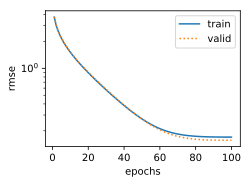

fold 0, train rmse 0.169787, valid rmse 0.156672
fold 1, train rmse 0.162258, valid rmse 0.189037
fold 2, train rmse 0.163926, valid rmse 0.168234
fold 3, train rmse 0.167767, valid rmse 0.154727
fold 4, train rmse 0.162472, valid rmse 0.182779
5-fold validation: avg train rmse 0.165242, avg valid rmse 0.170289


In [15]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

有时候你会发现⼀组参数的训练误差可以达到很低，但是在K折交叉验证上的误差可能反而较
⾼。这种现象很可能是由过拟合造成的。因此，当训练误差降低时，我们要观察K折交叉验证上
的误差是否也相应降低

## 预测并在Kaggle提交结果
下⾯定义预测函数。在预测之前，我们会使⽤完整的训练数据集来重新训练模型，并将预测结果
存成提交所需要的格式。

In [16]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                       num_epochs, lr, weight_decay, batch_size):
	net = get_net()
	train_ls, _ = train(net, train_features, train_labels, None, None,
						num_epochs, lr, weight_decay, batch_size)
	d2l.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
	print('train rmse %f' % train_ls[-1])
	preds = net(test_features).asnumpy()
	test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
	submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
	submission.to_csv('submission.csv', index=False)

设计好模型并调好超参数之后，下⼀步就是对测试数据集上的房屋样本做价格预测。如果我们得
到与交叉验证时差不多的训练误差，那么这个结果很可能是理想的，可以在Kaggle上提交结果。

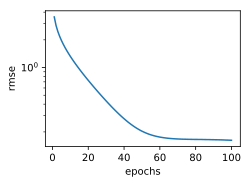

train rmse 0.162163


In [17]:
train_and_pred(train_features, test_features, train_labels, test_data,
    num_epochs, lr, weight_decay, batch_size) 

上述代码执⾏完之后会⽣成⼀个submission.csv⽂件。这个⽂件是符合Kaggle⽐赛要求的提交格
式的。这时，我们可以在Kaggle上提交我们预测得出的结果，并且查看与测试数据集上真实房价
（标签）的误差。具体来说有以下⼏个步骤：登录Kaggle⽹站，访问房价预测⽐赛⽹⻚，并点击右侧
“Submit Predictions”或“Late Submission”按钮；然后，点击⻚⾯下⽅“Upload Submission File”
图标所在的虚线框选择需要提交的预测结果⽂件；最后，点击⻚⾯最下⽅的“Make Submission”
按钮就可以查看结果了，如图3.9所⽰。

![Kaggle预测房价比赛的预测结果提交页面](../img/kaggle_submit2.png)

## 小结
- 通常需要对真实数据做预处理。
- 可以使⽤K折交叉验证来选择模型并调节超参数。